In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook


# libFM install

instructions: http://www.libfm.org/libfm-1.42.manual.pdf

But for use with python we adapt from https://github.com/jfloff/pywFM
```
git clone https://github.com/srendle/libfm /home/libfm
cd /home/libfm/
# taking advantage of a bug to allow us to save model #ShameShame
git reset --hard 91f8504a15120ef6815d6e10cc7dee42eebaab0f
make all
export LIBFM_PATH=/home/libfm/bin/
```




# LastFM

Download the dataset from here: http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html

Process with PrepLFM1K notebook, downloaded from: https://scholarworks.boisestate.edu/cs_scripts/4/ 

Then run the following cells and commands

## Log-normalizing # listens

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('lastfm-dataset-1K/' + 'lfm1k-play-counts.csv')

In [6]:
grouped_artists = df.groupby('artist')
sum_count = grouped_artists['count'].sum()
items_to_keep = sum_count[sum_count > 50].index

In [7]:
df = df[df['artist'].isin(items_to_keep)]

<IPython.core.display.Javascript object>


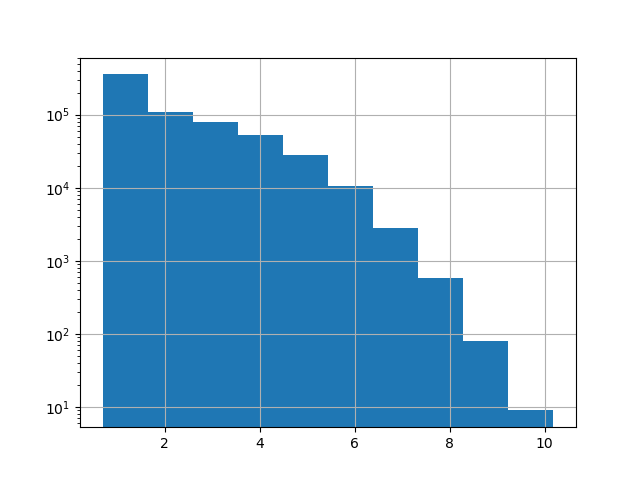

In [10]:
plt.figure()
(df['count']).hist(); plt.semilogy(); plt.show();

In [11]:
df['count'] = np.log(1+df['count'])

/home/moritz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df.describe()


,user,artist,count
count,638677.000000,638677.000000,638677.000000
mean,502.628105,12637.746518,0.987963
std,285.984730,18515.156469,0.424617
min,1.000000,1.000000,0.526589
25%,260.000000,1751.000000,0.526589
50%,512.000000,6569.000000,0.869742
75%,746.000000,15124.000000,1.327761
max,992.000000,176990.000000,2.414555


In [13]:
df.to_csv('lastfm-dataset-1K/' + 'lfm1k-log-play-counts.csv',
         index=False)

## Preparing data for libfm training

```
cd /home/sarah/recsys/data/lastfm/lastfm-dataset-1K
sed -i '1d' lfm1k-log-play-counts.csv
mv lfm1k-log-play-counts.csv original_lfm1k-log-play-counts.csv
shuf original_lfm1k-log-play-counts.csv > lfm1k-log-play-counts.csv
```


Train/Test


```

wc -l lfm1k-log-play-counts.csv
split -l 574809 lfm1k-log-play-counts.csv lfm1k-play-counts
mv lfm1k-play-countsaa lfm1k-play-count.train
mv lfm1k-play-countsab lfm1k-play-count.test

```

now into libfm format
``` 
~/Dropbox/recsys/rec-reachability/notebooks/triple_format_to_libfm.pl -in /home/sarah/recsys/data/lastfm/lastfm-dataset-1K/lfm1k-play-count.test,/home/sarah/recsys/data/lastfm/lastfm-dataset-1K/lfm1k-play-count.train -target 2 -separator "," -outmeta ~/recsys/data/lastfm/lastfm-dataset-1K/meta_1.text -outindex ~/recsys/data/lastfm/lastfm-dataset-1K/index_map_1.text
```

This gives us the true test set `lfm1k-play-count.test` and the true training set `lfm1k-play-count.train` along with `meta_1.text` and `index_map_1.text` which we use later to identify item factors with items in the dataset.


## Computing popularity values

In [14]:
import pandas as pd
import numpy as np
path = 'lastfm-dataset-1K/'

In [15]:
len(np.unique(df['train']['artist_id']))

KeyError: 'train'

In [16]:

df = {}
for s in ['test','train']:
    df[s] = pd.read_csv(path+'lfm1k-play-count.'+s, sep=',', header=None, names=['user_id','artist_id','rating'], usecols=[0,1,2])
    print('shape: {}'.format(df[s].shape))


shape: (63868, 3)
shape: (574809, 3)


In [17]:
indices = pd.read_csv(path+'index_map_1.text', header=None, sep=' ')

In [18]:
indices

,0,1,2,3
0,0,236,0,0.693147
1,1,11485,1,0.693147
2,0,840,2,1.098612
3,1,19282,3,1.098612
4,0,110,4,1.609438
...,...,...,...,...
25065,1,74370,25065,5.273000
25066,1,111308,25066,4.927254
25067,1,94432,25067,4.382027
25068,1,101634,25068,5.220356


In [19]:
artist_ids = indices[indices[0]==1][1]
artist_ids.shape

(24078,)

In [21]:
mid = 0

In [22]:
artist_id_ordered = []
for i,mid in enumerate(df['train']['artist_id']):
    if i % 10000 == 0: print('processing {}/{}'.format(i, df['train'].shape[0]))
    artist_id_ordered.append(np.where(artist_ids==mid)[0][0])
df['train']['artist_id_ordered'] = artist_id_ordered

processing 0/574809
processing 10000/574809
processing 20000/574809
processing 30000/574809
processing 40000/574809
processing 50000/574809
processing 60000/574809
processing 70000/574809
processing 80000/574809
processing 90000/574809
processing 100000/574809
processing 110000/574809
processing 120000/574809
processing 130000/574809
processing 140000/574809
processing 150000/574809
processing 160000/574809
processing 170000/574809
processing 180000/574809
processing 190000/574809
processing 200000/574809
processing 210000/574809
processing 220000/574809
processing 230000/574809
processing 240000/574809
processing 250000/574809
processing 260000/574809
processing 270000/574809
processing 280000/574809
processing 290000/574809
processing 300000/574809
processing 310000/574809
processing 320000/574809
processing 330000/574809
processing 340000/574809
processing 350000/574809
processing 360000/574809
processing 370000/574809
processing 380000/574809
processing 390000/574809
processing 400

In [23]:
artist_id_ordered = []
for i,mid in enumerate(df['test']['artist_id']):
    if i % 10000 == 0: print('processing {}/{}'.format(i, df['test'].shape[0]))
    artist_id_ordered.append(np.where(artist_ids==mid)[0][0])
df['test']['artist_id_ordered'] = artist_id_ordered

processing 0/63868
processing 10000/63868
processing 20000/63868
processing 30000/63868
processing 40000/63868
processing 50000/63868
processing 60000/63868


In [24]:
#saving
for s in ['train', 'test']:
    df[s].to_csv(path+'r1_indexed.'+s) 

In [25]:

df_artist_info = pd.DataFrame({})
df_artist_info['artist_id'] = list(artist_ids)
df_artist_info['ordered'] = list(range(1, len(artist_ids)+1))


In [26]:
df_artist_info.to_csv(path+'artist_info') 
df_artist_info

,artist_id,ordered
0,11485,1
1,19282,2
2,3328,3
3,3039,4
4,5242,5
...,...,...
24073,74370,24074
24074,111308,24075
24075,94432,24076
24076,101634,24077


In [28]:
datapath = 'lastfm-dataset-1K/'
print('Loading raw indexed data')
dfs = {}
for s in ['train', 'test']:
    dfs[s] = pd.read_csv(datapath+'r1_indexed.'+s, usecols=[1,2,3,4])
df_all = pd.concat([dfs['test'],dfs['train']])

df = pd.read_csv(datapath+'artist_info',usecols=[1,2])


Loading raw indexed data


In [29]:
df_all

,user_id,artist_id,rating,artist_id_ordered
0,236,11485,0.693147,0
1,840,19282,1.098612,1
2,110,3328,1.609438,2
3,181,3039,5.537334,3
4,696,5242,4.060443,4
...,...,...,...,...
574804,500,916,0.693147,1937
574805,412,1964,2.197225,603
574806,659,2875,0.693147,613
574807,634,12200,1.791759,513


In [30]:
# average genre rating and average genre number of ratings
median_ratings = {s:[] for s in ['train','test']}
n_ratings = {s:[] for s in ['train','test']}
ordered_id = []

for _, row in df.iterrows():
    i = row['artist_id']
    try:
        artist_id = df_all[df_all['artist_id'] == i]['artist_id_ordered'].iloc[0]
    except IndexError:
        print(row['artist_id'], row['artist_title'], df_all[df_all['artist_id']==i])
        artist_id = -1
    ordered_id.append(artist_id)
    for s in ['train','test']:
        ratings = dfs[s][dfs[s]['artist_id'] == i]['rating']
        median_ratings[s].append(np.median(ratings))
        n_ratings[s].append(len(ratings))
    

/home/moritz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/moritz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
for s in ['train','test']:
    df['n_ratings_{}'.format(s)] = n_ratings[s]
    df['median_ratings_{}'.format(s)] = median_ratings[s]

df['ordered_id'] = ordered_id


In [32]:
df = df.fillna(0)

In [33]:
#saving
df.to_csv(datapath+'artist_genres_stats.csv') 

# MovieLens 10M

download data from: https://grouplens.org/datasets/movielens/10m/ and unzip

then in the data directory, 
```
mv ratings.dat original_ratings.dat
shuf original_ratings.dat > ratings.dat
bash split_ratings.sh
```

Then using the libfm conversion script in this folder,
```
./triple_format_to_libfm.pl -in /home/sarah/Downloads/ml-10M100K/r1.test,/home/sarah/Downloads/ml-10M100K/r1.train -target 2 -delete_column 3 -separator "::" -outmeta /home/sarah/Downloads/ml-10M100K/meta_1.text -outindex /home/sarah/Downloads/ml-10M100K/index_map_1.text


```

## Computing popularity

In [34]:
path = 'ml-10M100K/'

In [35]:
from scipy.sparse import csr_matrix
import scipy

df = {}
for s in ['test','train']:
    df[s] = pd.read_csv(path+'r1.'+s, sep='::', header=None, names=['user_id','movie_id','rating'], usecols=[0,1,2])
    print('shape: {}'.format(df[s].shape))


/home/moritz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


shape: (2000010, 3)
shape: (8000044, 3)


In [ ]:
indices = pd.read_csv(path+'index_map_1.text', header=None, sep=' ')

In [ ]:
indices

In [ ]:
user_ids = indices[indices[0]==0][1]
user_ids.shape

In [ ]:
movie_ids = indices[indices[0]==1][1]
movie_ids.shape

In [ ]:
movie_ids

In [ ]:
movie_id_ordered = []
for i,mid in enumerate(df['train']['movie_id']):
    if i % 10000 == 0: print('processing {}/{}'.format(i, df['train'].shape[0]))
    movie_id_ordered.append(np.where(movie_ids==mid)[0][0])
df['train']['movie_id_ordered'] = movie_id_ordered

In [ ]:
df['train']['movie_id_ordered'] = movie_id_ordered

In [ ]:
df['train']

In [ ]:
movie_id_ordered = []
for i,mid in enumerate(df['test']['movie_id']):
    if i % 10000 == 0: print('processing {}/{}'.format(i, df['test'].shape[0]))
    movie_id_ordered.append(np.where(movie_ids==mid)[0][0])
df['test']['movie_id_ordered'] = movie_id_ordered

In [ ]:
#saving
for s in ['test', 'train']:
    df[s].to_csv(path+'r1_indexed.'+s) 

In [ ]:
datapath = '/home/sarah/Dropbox/CANOPY/code/'
print('Loading raw indexed data')

In [ ]:
df = pd.read_csv(path+'movies.dat', sep='::', header=None, names=['movie_id','movie_title','genres'], usecols=[0,1,2])


In [ ]:
genres = ['Action',
    'Adventure',
    'Animation',
    'Children',
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
    'Western']
genre_indicator = {g:[] for g in genres}

In [ ]:
for movie_genres in df['genres']:
    for g in genres:
        if g in movie_genres:
            genre_indicator[g].append(1)
        else:
            genre_indicator[g].append(0)
for g in genres:
    df[g] = genre_indicator[g]

In [ ]:
# average genre rating and average genre number of ratings
average_ratings = {s:[] for s in ['test','train']}
n_ratings = {s:[] for s in ['test','train']}
ordered_id = []

for _, row in df.iterrows():
    i = row['movie_id']
    try:
        movie_id = df_all[df_all['movie_id'] == i]['movie_id_ordered'].iloc[0]
    except IndexError:
        print(row['movie_id'], row['movie_title'], df_all[df_all['movie_id']==i])
        movie_id = -1
    ordered_id.append(movie_id)
    for s in ['test','train']:
        ratings = dfs[s][dfs[s]['movie_id'] == i]['rating']
        average_ratings[s].append(np.mean(ratings))
        n_ratings[s].append(len(ratings))
    

In [ ]:
for s in ['test','train']:
    df['n_ratings_{}'.format(s)] = n_ratings[s]
    df['average_ratings_{}'.format(s)] = average_ratings[s]

df['ordered_id'] = ordered_id

In [ ]:
#saving
df.to_csv(datapath+'movie_genres_stats.csv') 